In [1]:
#Zip Datei entpacken
import zipfile
import os
import tifffile
import glob

# Path to our Zip file with the training data
zip_path = "C:/Users/hendr/Desktop/ML_Seminar/MoNuSAC_images_and_annotations.zip"

# Paths to the data and the masks
extract_dir_data = "data"
extract_dir_masks  = "MoNuSAC_masks" #load masks instead of datasets (generatet via binary_mask_generation)

# Ordner erstellen, falls nicht vorhanden
#os.makedirs(extract_dir_data, exist_ok=True)

# ZIP entpacken
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_dir_data)

# Get the tif files
tif_files_data = glob.glob(os.path.join(extract_dir_data,"**", "*.tif"), recursive=True)
print(f"Found TIFF-data: {len(tif_files_data)}")

tif_files_masks = glob.glob(os.path.join(extract_dir_masks,"**", "*.tif"), recursive=True)
print(f"Found TIFF-Masks: {len(tif_files_masks)}")

Found TIFF-data: 209
Found TIFF-Masks: 394


Loaded number of images: 209


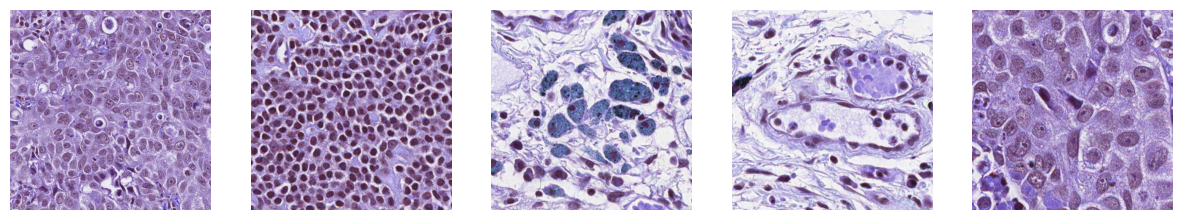

In [2]:
import matplotlib.pyplot as plt

images_original = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_original.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of images:", len(images_original))

if len(images_original) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_original))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_original[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

Loaded number of images: 394


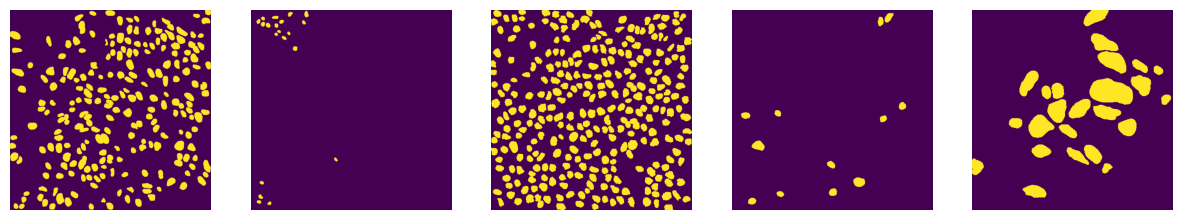

In [3]:
import matplotlib.pyplot as plt

images_masks = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_masks if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_masks.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of images:", len(images_masks))

if len(images_masks) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_masks))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_masks[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training läuft auf: {device}")

# Parameter
IMG_SIZE = 256  # scale pictures
BATCH_SIZE = 8  # how many pictures we look at the same time
LEARNING_RATE = 1e-4 # size of steps to min error
EPOCHS = 100 # how many times we look at every picture in our set

Training läuft auf: cuda


In [10]:
import os
import glob
import numpy as np
import tifffile
import torch
import random
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

all_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

class MoNuSACDataset(Dataset):
    def __init__(self, image_paths, mask_base_dir, transform=None, augment=False):
        self.image_paths = image_paths
        self.mask_base_dir = mask_base_dir
        self.transform = transform
        self.augment = augment
        self.IMG_SIZE = IMG_SIZE
        
        self.class_map = {
            "Epithelial": 1, "Lymphocyte": 2, "Macrophage": 3, "Neutrophil": 4
        }
        
        self.mask_lookup = {}
        
        # stuff to get the correct files for original and mask
        patient_folders = glob.glob(os.path.join(mask_base_dir, "*"))
        for i in patient_folders:
            if os.path.isdir(i):
                sub_dirs = glob.glob(os.path.join(i, "*"))
                for mask_folder_path in sub_dirs:
                    if os.path.isdir(mask_folder_path):
                        folder_name = os.path.basename(mask_folder_path)
                        self.mask_lookup[folder_name] = mask_folder_path
                        if folder_name.endswith("_1"):
                            clean_name = folder_name[:-2]
                            self.mask_lookup[clean_name] = mask_folder_path

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # load images
        img_path = self.image_paths[idx]
        image = tifffile.imread(img_path)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_folder = self.mask_lookup.get(base_name)
        
        h, w = image.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64) 
        
        # stes the correct cell in the masks
        if mask_folder:
            for cell_type, class_idx in self.class_map.items():
                search_path = os.path.join(mask_folder, cell_type, "*.tif")
                found_files = glob.glob(search_path)
                if found_files:
                    try:
                        filepath = found_files[0]
                        layer = tifffile.imread(filepath)
                        if layer.shape[0] == h and layer.shape[1] == w:
                            mask[layer > 0] = class_idx
                    except:
                        pass
        
        # convert to PIL
        image_pil = Image.fromarray(image).convert("RGB")
        mask_pil = Image.fromarray(mask.astype(np.uint8))
        
        # Resize
        image_pil = image_pil.resize((self.IMG_SIZE, self.IMG_SIZE))
        mask_pil = mask_pil.resize((self.IMG_SIZE, self.IMG_SIZE), resample=Image.NEAREST)
        
        # data augmentaion randomly 50% chance
        if self.augment:
            if random.random() > 0.5:
                image_pil = TF.hflip(image_pil)
                mask_pil = TF.hflip(mask_pil)

            if random.random() > 0.5:
                image_pil = TF.vflip(image_pil)
                mask_pil = TF.vflip(mask_pil)

            # Random rotation of 90 180 or 270 degree
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                image_pil = TF.rotate(image_pil, angle)
                mask_pil = TF.rotate(mask_pil, angle)

        # -----------------------------------------------------------
        
        # to Tensor
        img_tensor = transforms.ToTensor()(image_pil) 
        mask_array = np.array(mask_pil, dtype=np.int64)
        mask_tensor = torch.from_numpy(mask_array)
        
        return img_tensor, mask_tensor

# create the dataset
extract_dir_masks = "MoNuSAC_masks" 

# augment=True only in training
train_dataset = MoNuSACDataset(train_files, extract_dir_masks, augment=True)
val_dataset = MoNuSACDataset(val_files, extract_dir_masks, augment=False)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True) # Batchsize angepasst für 512px
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

print("Augmentation aktiviert für Training-Set.")

Augmentation aktiviert für Training-Set.


In [54]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        
        #  laod Encoder (ResNet34)
        #base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        
        # Layer 0: Conv1, BN, ReLU (Eingang)
        self.layer0 = nn.Sequential(*base_layers[:3]) 
        
        # ResNet50 hat folgende Output-Channels:
        # layer1: 256 channels (ResNet34 hatte 64)
        # layer2: 512 channels (ResNet34 hatte 128)
        # layer3: 1024 channels (ResNet34 hatte 256)
        # layer4: 2048 channels (ResNet34 hatte 512)


        # Layer 1 bis 4: Die ResNet Blöcke
        # layer1 ändert Größe nicht (64 channels)
        # layer2 halbiert Größe (128 channels)
        # layer3 halbiert Größe (256 channels)
        # layer4 halbiert Größe (512 channels) -> Das ist der "Bottleneck"
        self.layer1 = nn.Sequential(*base_layers[3:5]) # MaxPool + Layer1
        self.layer2 = base_layers[5]
        self.layer3 = base_layers[6]
        self.layer4 = base_layers[7]
        
        # 2. Den Decoder bauen (Der Weg nach oben)
        # Wir brauchen Upsampling und müssen die Channels reduzieren
        
        self.up4 = self.expand_block(2048, 1024)  # upwards path we want to get from our 512 channels up to 256
        self.up3 = self.expand_block(1024 + 1024, 512) # +256 wegen Skip Connection aus layer3
        self.up2 = self.expand_block(512 + 512, 256)  # +128 wegen Skip Connection aus layer2
        self.up1 = self.expand_block(256 + 256, 64)    # +64 wegen Skip Connection aus layer1
        

        #resnet 34
        """
        self.up4 = self.expand_block(512, 256)  # upwards path we want to get from our 512 channels up to 256
        self.up3 = self.expand_block(256 + 256, 128) # +256 wegen Skip Connection aus layer3
        self.up2 = self.expand_block(128 + 128, 64)  # +128 wegen Skip Connection aus layer2
        self.up1 = self.expand_block(64 + 64, 64)    # +64 wegen Skip Connection aus layer1
        """

        # Wir sind bei layer1 (Größe / 4). Wir müssen also x4 vergrößern, 
        # um auf Originalgröße zu kommen.
        # Kernel=2, Stride=2 bedeutet: Mach aus 1 Pixel -> 2x2 Pixel (Faktor 2)
        self.final_upsample = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        # Finaler Layer um auf die Anzahl der Klassen (5) zu kommen
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def expand_block(self, in_channels, out_channels):
        """Hilfsfunktion für einen Decoder-Block
            Does upsampling and also should flatten our the artifacts
        """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        )

    def forward(self, x):
        # --- ENCODER (ResNet) ---
        layer0 = self.layer0(x)           # Output: 64, H/2, W/2
        layer1 = self.layer1(layer0)      # Output: 64, H/4, W/4
        layer2 = self.layer2(layer1)      # Output: 128, H/8, W/8
        layer3 = self.layer3(layer2)      # Output: 256, H/16, W/16
        layer4 = self.layer4(layer3)      # Output: 512, H/32, W/32
        
        
        # 1. Hoch von Layer 4
        up4 = self.up4[0](layer4)         # Upsample
        up4 = self.up4[1](up4)            # Conv
        
        # 2. Hoch von Layer 3 (Mit Skip Connection von layer3)
        # Wir kleben (cat) layer3 an das upgesamplete Bild
        cat3 = torch.cat([up4, layer3], dim=1) 
        up3 = self.up3[0](cat3)
        up3 = self.up3[1](up3)
        
        # 3. Hoch von Layer 2 (Mit Skip Connection von layer2)
        cat2 = torch.cat([up3, layer2], dim=1)
        up2 = self.up2[0](cat2)
        up2 = self.up2[1](up2)
        
        # 4. Hoch von Layer 1 (Mit Skip Connection von layer1)
        cat1 = torch.cat([up2, layer1], dim=1)
        up1 = self.up1[0](cat1)
        up1 = self.up1[1](up1)
        
        # Jetzt sind wir bei H/4, W/4. Wir müssen noch auf Originalgröße H, W
        # Das ResNet macht am Anfang direkt /2 und dann MaxPool /2.
        # Wir brauchen also noch einen finalen Upsample Schritt für Layer0
        
        #final_up = nn.functional.interpolate(up1, scale_factor=2, mode='bilinear', align_corners=True)
        final_up = self.final_upsample(up1)
        
        return self.final_conv(final_up)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#should work better with medical  pictures beacuse it will ignore the background. Crossentropy loss doesn't do this.
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: [Batch, Classes, H, W] (Logits vom U-Net)
        # targets: [Batch, H, W] (Indices 0-4)
        
        # 1. Softmax auf die Inputs anwenden, um Wahrscheinlichkeiten zu bekommen
        inputs = F.softmax(inputs, dim=1)
        
        # 2. Targets in One-Hot-Encoding umwandeln
        # Von [B, H, W] zu [B, H, W, C]
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        
        # Dimensionen tauschen zu [B, C, H, W] damit es zu den inputs passt
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        # 3. Dice Score berechnen
        # Intersection: Elementweise Multiplikation und Summe über H und W
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        
        # Union: Summe der Inputs + Summe der Targets
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        # Dice Formel: 2*Inter / (Union + smooth)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Durchschnitt über alle Klassen im Batch nehmen
        # 1 - Dice, da wir minimieren wollen (Dice=1 ist perfekt, Loss=0 ist perfekt)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice

    def forward(self, inputs, targets):
        loss_ce = self.ce(inputs, targets)
        loss_dice = self.dice(inputs, targets)
        
        # Man kann hier auch gewichten, z.B. 0.5 * ce + 0.5 * dice
        # Aber einfache Addition funktioniert meist super.
        return (self.weight_ce * loss_ce) + (self.weight_dice * loss_dice)
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Standard Cross Entropy berechnen (aber nicht reduzieren, wir brauchen den Fehler pro Pixel)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # pt ist die Wahrscheinlichkeit, dass das Modell richtig lag
        pt = torch.exp(-ce_loss)
        
        # Die Magie: (1-pt)^gamma gewichtet schwierige Beispiele höher
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()
    
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_focal=1.0):
        super(CombinedFocalDiceLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=2)
        
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal

    def forward(self, inputs, targets):
        loss_dice = self.dice(inputs, targets)
        loss_focal = self.focal(inputs, targets)
        
        return (self.weight_dice * loss_dice) + (self.weight_focal * loss_focal)

In [56]:
model = ResNetUNet(n_classes=5).to(device)
#criterion = CombinedLoss(weight_dice=0.5, weight_ce=0.5)
#criterion = DiceLoss()
#criterion = nn.CrossEntropyLoss()
criterion = CombinedFocalDiceLoss(weight_dice=0.5, weight_focal=0.5)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Listen zum Speichern der Historie
train_loss_history = []
val_loss_history = []   

print("Starte Training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Durchschnittlichen Loss für diese Epoche berechnen
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    # Durchschnittlichen Val-Loss berechnen
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
            
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

print("Training beendet!")

Starte Training...
Epoch [1/100], Train Loss: 0.7821, Val Loss: 0.6459
Epoch [2/100], Train Loss: 0.5802, Val Loss: 0.5591
Epoch [3/100], Train Loss: 0.5454, Val Loss: 0.5241
Epoch [4/100], Train Loss: 0.5343, Val Loss: 0.5300
Epoch [5/100], Train Loss: 0.5200, Val Loss: 0.5136
Epoch [6/100], Train Loss: 0.5054, Val Loss: 0.5086
Epoch [7/100], Train Loss: 0.4915, Val Loss: 0.5041
Epoch [8/100], Train Loss: 0.4830, Val Loss: 0.4916
Epoch [9/100], Train Loss: 0.4688, Val Loss: 0.4942
Epoch [10/100], Train Loss: 0.4599, Val Loss: 0.5132
Epoch [11/100], Train Loss: 0.4477, Val Loss: 0.4439
Epoch [12/100], Train Loss: 0.4463, Val Loss: 0.4582
Epoch [13/100], Train Loss: 0.4424, Val Loss: 0.5004
Epoch [14/100], Train Loss: 0.4339, Val Loss: 0.4409
Epoch [15/100], Train Loss: 0.4295, Val Loss: 0.4492
Epoch [16/100], Train Loss: 0.4305, Val Loss: 0.4568
Epoch [17/100], Train Loss: 0.4236, Val Loss: 0.4379
Epoch [18/100], Train Loss: 0.4184, Val Loss: 0.4563
Epoch [19/100], Train Loss: 0.4169, 

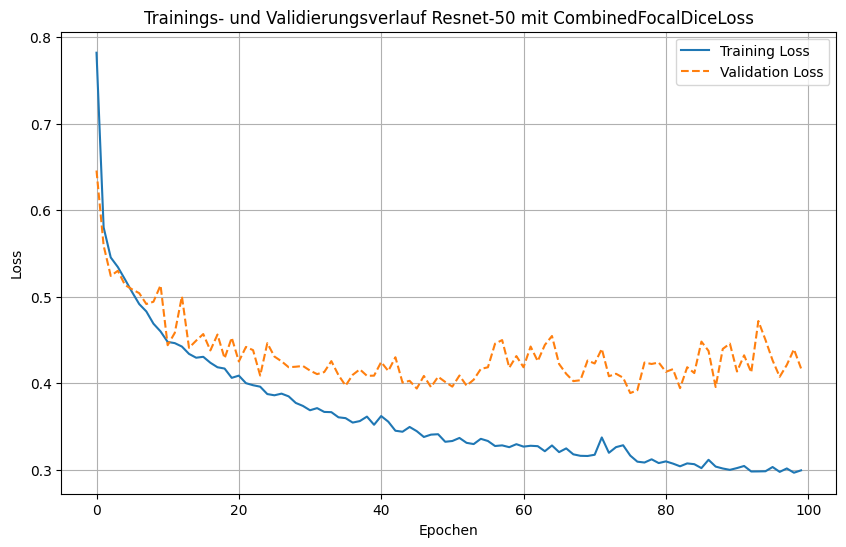

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')

plt.title('Trainings- und Validierungsverlauf Resnet-50 mit CombinedFocalDiceLoss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Zeige zufällige Samples an den Indizes: [21, 6, 28]


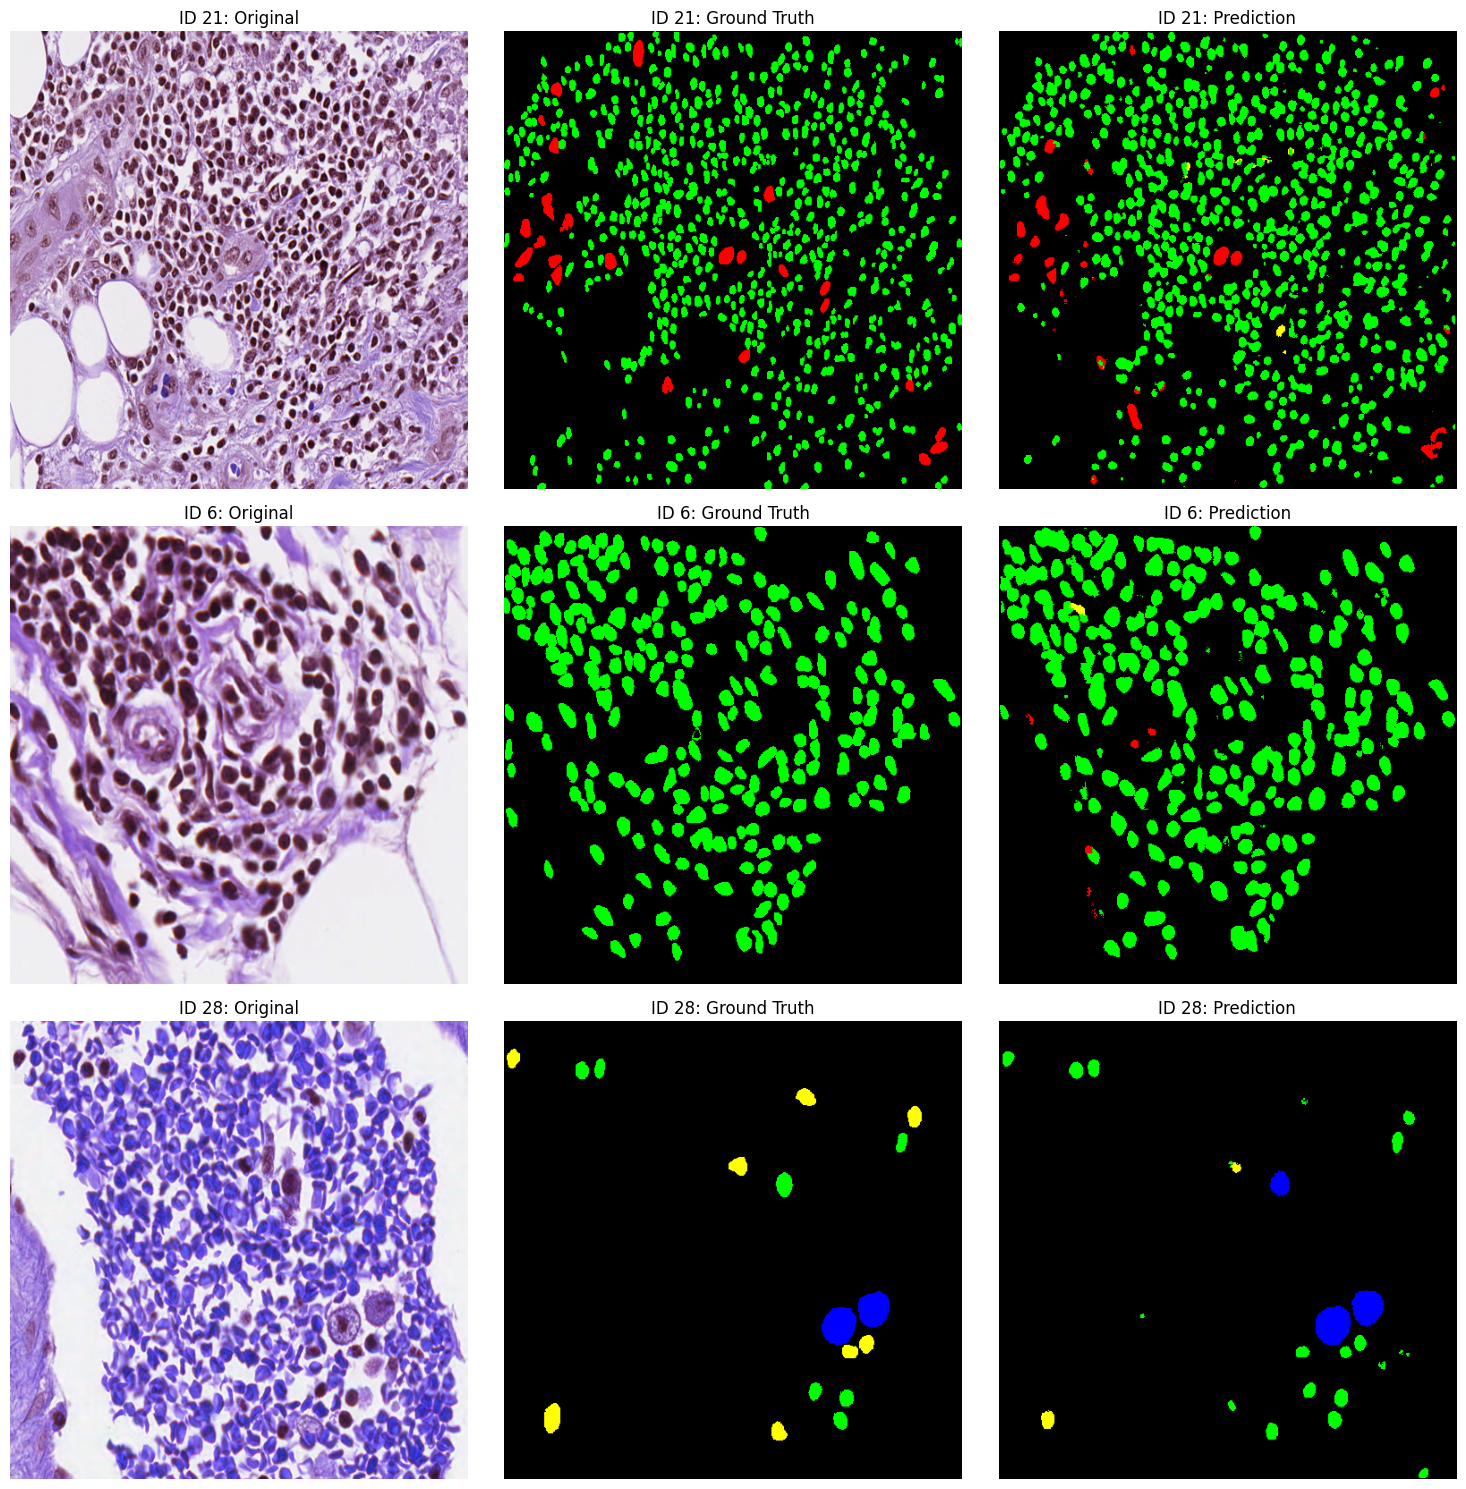

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

class_colors_map = {
    0: np.array([0, 0, 0]),       # Hintergrund: Schwarz
    1: np.array([255, 0, 0]),     # Epithelial: Rot
    2: np.array([0, 255, 0]),     # Lymphocyte: Grün
    3: np.array([0, 0, 255]),     # Macrophage: Blau
    4: np.array([255, 255, 0])    # Neutrophil: Gelb
}

def decode_mask_to_rgb(mask_2d):
    """Wandelt Index-Maske (0-4) in RGB Bild um"""
    h, w = mask_2d.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in class_colors_map.items():
        rgb_image[mask_2d == class_idx] = color
    return rgb_image

num_samples = 3
model.eval()

total_val_images = len(val_dataset)
# Sicherheit, falls weniger als 3 Bilder da sind
count = min(num_samples, total_val_images)
indices = random.sample(range(total_val_images), count)

print(f"Zeige zufällige Samples an den Indizes: {indices}")

plt.figure(figsize=(15, 5 * count))

for i, idx in enumerate(indices):
    # 1. Daten laden
    img_tensor, mask_tensor = val_dataset[idx]
    
    # 2. Vorhersage machen
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        # Argmax liefert die Klasse mit der höchsten Wahrscheinlichkeit
        prediction_tensor = torch.argmax(output, dim=1).cpu().squeeze(0)

    # 3. Umwandeln für Anzeige (Tensor -> Numpy -> RGB)
    img_display = img_tensor.permute(1, 2, 0).numpy()
    mask_display = decode_mask_to_rgb(mask_tensor.numpy())
    pred_display = decode_mask_to_rgb(prediction_tensor.numpy())

    # 4. Plotten
    # Spalte 1: Original
    plt.subplot(count, 3, i*3 + 1)
    plt.imshow(img_display)
    plt.title(f"ID {idx}: Original")
    plt.axis("off")

    # Spalte 2: Echte Maske
    plt.subplot(count, 3, i*3 + 2)
    plt.imshow(mask_display)
    plt.title(f"ID {idx}: Ground Truth")
    plt.axis("off")

    # Spalte 3: Vorhersage
    plt.subplot(count, 3, i*3 + 3)
    plt.imshow(pred_display)
    plt.title(f"ID {idx}: Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()